##### Convolutional Neural Networks

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
import torch
import numpy as np

# Determine the best available device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA is available! Using GPU...')
elif torch.backends.mps.is_available():
    device = torch.device('mps')  # Apple Metal (M1/M2 chips)
    print('MPS is available! Using Apple GPU...')
else:
    device = torch.device('cpu')
    print('No GPU available, using CPU...')

MPS is available! Using Apple GPU...


---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

**CIFAR-10** is a widely-used benchmark dataset in computer vision and deep learning. Here's what you need to know:

##### What is CIFAR-10?
CIFAR-10 (Canadian Institute For Advanced Research) is a collection of **60,000 color images** that are commonly used for training and testing machine learning models, particularly convolutional neural networks (CNNs).

##### Key Characteristics:
- **Image Size**: 32×32 pixels (small, low-resolution images)
- **Color**: RGB (3 channels)
- **Total Images**: 60,000 images
  - **Training Set**: 50,000 images
  - **Test Set**: 10,000 images
- **Classes**: 10 different categories with 6,000 images per class

##### The 10 Classes:
1. **Airplane**
2. **Automobile** 
3. **Bird**
4. **Cat**
5. **Deer**
6. **Dog**
7. **Frog**
8. **Horse**
9. **Ship**
10. **Truck**

##### Why CIFAR-10 is Important:
1. **Benchmark Dataset**: It's a standard benchmark for comparing different machine learning algorithms
2. **Manageable Size**: Small enough to train models quickly but complex enough to be challenging
3. **Real-world Objects**: Contains natural images (not synthetic), making it more realistic than simpler datasets
4. **Balanced**: Equal number of images per class prevents bias
5. **Preprocessing**: Images are already normalized and ready to use

##### Challenges:
- **Low Resolution**: 32×32 is quite small, making fine details hard to distinguish
- **Intra-class Variation**: Objects can appear in different orientations, lighting, and backgrounds
- **Inter-class Similarity**: Some classes (like cats vs dogs) can be similar


Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

---


In [2]:
import torchvision.transforms
import multiprocessing
from helpers import get_train_val_data_loaders, get_test_data_loader

"""
PyTorch Packages Comparison: torch vs torchvision

torch (PyTorch Core):
    - Primary package for deep learning
    - Core Features:
        • Tensor operations (CPU/GPU/MPS)
        • Neural network building blocks (nn.Module, layers)
        • Automatic differentiation (autograd)
        • Optimizers (SGD, Adam, etc.)
        • Basic data utilities (Dataset, DataLoader)
    - Usage:
        import torch
        import torch.nn as nn
        import torch.optim as optim

torchvision:
    - Computer vision extension for PyTorch
    - Key Features:
        • Prepackaged datasets (CIFAR10, ImageNet, etc.)
        • Image transformations (transforms module)
        • Pretrained vision models (ResNet, VGG, etc.)
        • Image/video utilities
    - Usage: 
        import torchvision
        import torchvision.datasets as datasets
        import torchvision.transforms as transforms

Relationship:
    - torchvision builds on torch's core functionality
    - torch provides the engine, torchvision provides vision-specific tools
    - Always need torch installed to use torchvision

Example Integration:
    # torch for model building
    model = torch.nn.Sequential(
        torch.nn.Linear(784, 256),
        torch.nn.ReLU()
    )
    
    # torchvision for data
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])
    data = torchvision.datasets.CIFAR10('./data', transform=transform)
"""

# number of subprocesses to use for data loading
num_workers = multiprocessing.cpu_count()
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

"""
Creates a composition of image transformations for CIFAR-10 preprocessing.

This transform pipeline performs two sequential operations:
1. ToTensor(): Converts PIL Image or numpy array (HxWxC, 0-255) to 
   PyTorch tensor (CxHxW, 0.0-1.0)
2. Normalize(): Normalizes tensor with mean=0.5 and std=0.5 for each RGB channel,
   transforming pixel values from [0.0, 1.0] to [-1.0, 1.0] range

The normalization formula applied per channel:
    normalized_pixel = (pixel - 0.5) / 0.5

Returns:
    torchvision.transforms.Compose: Composed transformation pipeline
    
Example:
    Original pixel 128 → 0.5 (ToTensor) → 0.0 (Normalize)
    White pixel 255 → 1.0 (ToTensor) → 1.0 (Normalize)  
    Black pixel 0 → 0.0 (ToTensor) → -1.0 (Normalize)
"""
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# If you want to refresh how to load and split data in pytorch, open the helpers.py file
# and read the code. We have documented it with comments so you can follow along easily
train_dl, valid_dl = get_train_val_data_loaders(batch_size, valid_size, transforms, num_workers)
test_dl = get_test_data_loader(batch_size, transforms, num_workers)

# For convenience let's group them together in a dictionary
data_loaders = {
    'train': train_dl,
    'valid': valid_dl,
    'test': test_dl
}

Files already downloaded and verified
Files already downloaded and verified


In [3]:
"""
specify the CIFAR10 image classes
"""
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

### Visualize a Batch of Training Data

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img, sub):
    img = img / 2 + 0.5  # unnormalize
    sub.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    sub.axis("off")

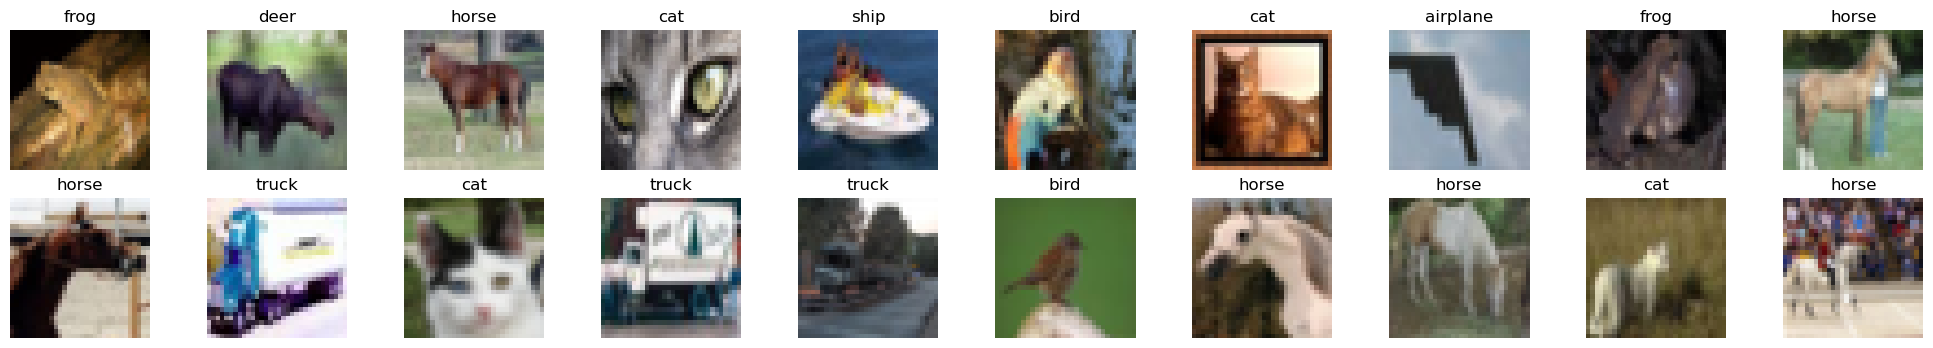

In [5]:
# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
# display 20 images
fig, subs = plt.subplots(2, 10, figsize=(25, 4))

for i, sub in enumerate(subs.flatten()):
    imshow(images[i], sub)
    sub.set_title(classes[labels[i]])
    
plt.show()

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

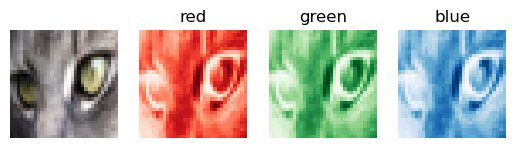

In [6]:
"""
Visualizes an RGB image and its individual color channels.

Purpose:
    Displays a composite RGB image alongside its separate red, green, and blue 
    channels to demonstrate how color images are constructed from channels.

Parameters (implied from context):
    images: A batch of images where each image has shape (3, H, W) for RGB channels
    index: Index 3 selects the 4th image from the batch (0-based indexing)

Workflow:
    1. Extracts one RGB image from batch and removes singleton dimensions
    2. Creates 4 subplots: composite + individual channels
    3. Applies appropriate colormaps to each channel visualization
    4. Displays with titles and clean formatting

Key Functions/Methods:
    - np.squeeze(): Removes single-dimensional entries
    - plt.subplots(): Creates figure and subplot grid
    - imshow(): Displays image data (custom or matplotlib's)

Example Usage:
    # Assuming 'images' is a batch of CIFAR-10 images
    visualize_rgb_channels(images, index=3)

Output:
    A 1x4 grid showing:
    - Left: Original RGB image
    - Middle 3: Red, Green, Blue channels separately

Notes:
    - Channels assumed to be in RGB order (index 0: R, 1: G, 2: B)
    - First subplot uses a custom 'imshow' function (likely handles normalization)
    - Subsequent subplots use matplotlib's imshow with channel-specific colormaps
    - 'Reds', 'Greens', 'Blues' colormaps highlight intensity per channel
"""

# The actual code for documentation:
rgb_img = np.squeeze(images[3])  # Remove batch dimension from 4th image
channels = ['composite', 'red', 'green', 'blue']
cmaps = [None, 'Reds', 'Greens', 'Blues']

fig, subs = plt.subplots(1, 4)  # Create 1x4 subplot grid

for i, sub in enumerate(subs.flatten()):
    if i == 0:
        imshow(rgb_img, sub)  # Custom display for composite image
        continue
    
    img = rgb_img[i-1]  # Get individual channel (R, G, or B)
    sub.imshow(img, cmap=cmaps[i])  # Show with channel-appropriate colormap
    sub.set_title(channels[i])
    sub.axis("off")
        
plt.show()

---

##### Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

This time, you'll define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, you'll use the following:
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.


```mermaid
flowchart TD
    Input["Input Image<br>3×32×32"] --> Conv1["Conv2d Layer 1<br>3→16 channels<br>3×3 kernel, padding=1<br>Output: 16×32×32"]
    Conv1 --> ReLU1["ReLU Activation 1"]
    ReLU1 --> Pool1["MaxPool2d 1<br>2×2, stride=2<br>Output: 16×16×16"]
    
    Pool1 --> Conv2["Conv2d Layer 2<br>16→32 channels<br>3×3 kernel, padding=1<br>Output: 32×16×16"]
    Conv2 --> ReLU2["ReLU Activation 2"]
    ReLU2 --> Pool2["MaxPool2d 2<br>2×2, stride=2<br>Output: 32×8×8"]
    
    Pool2 --> Conv3["Conv2d Layer 3<br>32→64 channels<br>3×3 kernel, padding=1<br>Output: 64×8×8"]
    Conv3 --> ReLU3["ReLU Activation 3"]
    ReLU3 --> Pool3["MaxPool2d 3<br>2×2, stride=2<br>Output: 64×4×4"]
    
    Pool3 --> Flatten["Flatten<br>Output: 1024<br>(64×4×4)"]
    Flatten --> FC1["Fully Connected 1<br>1024 (64×16)→500 neurons"]
    FC1 --> Dropout["Dropout<br>p=0.5"]
    Dropout --> ReLUFC["ReLU Activation"]
    ReLUFC --> FC2["Fully Connected 2<br>500→n_classes neurons"]
    FC2 --> Output["Output<br>(Class Probabilities)"]
    
    style Input fill:#BCFB89,stroke:#333,stroke-width:2px,color:black
    style Conv1 fill:#FBF266,stroke:#333,stroke-width:2px,color:black
    style ReLU1 fill:#FA756A,stroke:#333,stroke-width:2px,color:black
    style Pool1 fill:#9AE4F5,stroke:#333,stroke-width:2px,color:black
    style Conv2 fill:#FBF266,stroke:#333,stroke-width:2px,color:black
    style ReLU2 fill:#FA756A,stroke:#333,stroke-width:2px,color:black
    style Pool2 fill:#9AE4F5,stroke:#333,stroke-width:2px,color:black
    style Conv3 fill:#FBF266,stroke:#333,stroke-width:2px,color:black
    style ReLU3 fill:#FA756A,stroke:#333,stroke-width:2px,color:black
    style Pool3 fill:#9AE4F5,stroke:#333,stroke-width:2px,color:black
    style Flatten fill:#FCEB14,stroke:#333,stroke-width:2px,color:black
    style FC1 fill:#0096D9,stroke:#333,stroke-width:2px,color:black
    style Dropout fill:#FE9237,stroke:#333,stroke-width:2px,color:black
    style ReLUFC fill:#FA756A,stroke:#333,stroke-width:2px,color:black
    style FC2 fill:#0096D9,stroke:#333,stroke-width:2px,color:black
    style Output fill:#BCFB89,stroke:#333,stroke-width:2px,color:black
```

---

##### Conv2d Layer 1: Detailed Calculation

Let's break down how the convolution operation transforms the input and why the channels increase:

##### Input Analysis
- **Input**: $3 \times 32 \times 32$ (3 color channels: RGB)
- **Convolution Parameters**: 
  - Input channels: $3$
  - Output channels: $16$ 
  - Kernel size: $3 \times 3$
  - Padding: $1$
  - Stride: $1$ (default)

##### Channel Expansion Mechanism

The key insight is that **each output channel requires a separate set of kernels** for all input channels:

```mermaid
flowchart TD
    Input["Input<br>3×32×32<br>(R, G, B channels)"] --> K1["Kernel Set 1<br>3 kernels of 3×3<br>(one per input channel)"]
    Input --> K2["Kernel Set 2<br>3 kernels of 3×3"]
    Input --> K3["..."]
    Input --> K16["Kernel Set 16<br>3 kernels of 3×3"]
    
    K1 --> O1["Output Channel 1<br>32×32"]
    K2 --> O2["Output Channel 2<br>32×32"]
    K3 --> O3["..."]
    K16 --> O16["Output Channel 16<br>32×32"]
    
    O1 --> Final["Final Output<br>16×32×32"]
    O2 --> Final
    O3 --> Final
    O16 --> Final
    
    style Input fill:#E8F4FD,color:#000
    style K1 fill:#D1E7FB,color:#000
    style K2 fill:#D1E7FB,color:#000
    style K16 fill:#D1E7FB,color:#000
    style O1 fill:#A3CCF6,color:#000
    style O2 fill:#A3CCF6,color:#000
    style O16 fill:#A3CCF6,color:#000
    style Final fill:#75B1F1,color:#000
```

##### Understanding the Number of Kernel Sets (Output Channels)

The number of kernel sets (16 in this case) is a **design choice** by programmer - it's a hyperparameter that we design based on our architectural decisions.

##### Why Do We Need Multiple Kernel Sets?

Each kernel set learns to detect **different visual patterns or features**. Think of it this way:

- **Kernel Set 1** might learn to detect **horizontal edges**
- **Kernel Set 2** might learn to detect **vertical edges**  
- **Kernel Set 3** might learn to detect **diagonal lines**
- **Kernel Set 4** might learn to detect **curves**
- **Kernel Set 5** might learn to detect **corners**
- ... and so on

```mermaid
flowchart TD
    Input["RGB Image<br>3×32×32"] --> K1["Kernel Set 1<br>Horizontal Edge Detector"]
    Input --> K2["Kernel Set 2<br>Vertical Edge Detector"]
    Input --> K3["Kernel Set 3<br>Diagonal Line Detector"]
    Input --> K4["Kernel Set 4<br>Curve Detector"]
    Input --> K5["..."]
    Input --> K16["Kernel Set 16<br>Some Other Feature"]
    
    K1 --> F1["Feature Map 1<br>Shows horizontal edges"]
    K2 --> F2["Feature Map 2<br>Shows vertical edges"]
    K3 --> F3["Feature Map 3<br>Shows diagonal lines"]
    K4 --> F4["Feature Map 4<br>Shows curves"]
    K5 --> F5["..."]
    K16 --> F16["Feature Map 16<br>Shows other patterns"]
    
    style Input fill:#E8F4FD,color:#000
    style K1 fill:#FFE0E0,color:#000
    style K2 fill:#E0FFE0,color:#000
    style K3 fill:#E0E0FF,color:#000
    style K4 fill:#FFFFE0,color:#000
    style K16 fill:#FFE0FF,color:#000
    style F1 fill:#FFCCCC,color:#000
    style F2 fill:#CCFFCC,color:#000
    style F3 fill:#CCCCFF,color:#000
    style F4 fill:#FFFFCC,color:#000
    style F16 fill:#FFCCFF,color:#000
```

##### How Do We Choose the Number of Output Channels?

The choice of 16 output channels is a **design decision** based on several factors:

**1. Representational Capacity**
- More channels = ability to learn more diverse features
- Fewer channels = simpler model, less computational cost

**2. Common Architectural Patterns**
```
Typical progression in CNNs:
3 → 16 → 32 → 64 → 128 → 256 → 512

Or variations like:
3 → 32 → 64 → 128 → 256 → 512
3 → 64 → 128 → 256 → 512 → 1024
```

**3. Problem Complexity**
- Simple datasets (like CIFAR-10): Start with fewer channels (16, 32)
- Complex datasets (like ImageNet): Use more channels (64, 128+)

##### Mathematical Relationship

For any convolutional layer:
```python
nn.Conv2d(in_channels, out_channels, kernel_size, padding)
```

**Parameters required**:
$$\text{Weights} = \text{out\_channels} \times \text{in\_channels} \times \text{kernel\_height} \times \text{kernel\_width}$$
$$\text{Biases} = \text{out\_channels}$$
$$\text{Total} = (\text{out\_channels} \times \text{in\_channels} \times \text{kernel\_height} \times \text{kernel\_width}) + \text{out\_channels}$$

For our example:
$$\text{Total} = (16 \times 3 \times 3 \times 3) + 16 = 432 + 16 = 448 \text{ parameters}$$

##### Design Trade-offs

```mermaid
flowchart LR
    A["Fewer Channels<br>(e.g., 8)"] --> A1["Pros:<br>• Faster training<br>• Less memory<br>• Fewer parameters"]
    A --> A2["Cons:<br>• Limited feature diversity<br>• May underfit<br>• Less expressive"]
    
    B["More Channels<br>(e.g., 64)"] --> B1["Pros:<br>• Rich feature learning<br>• Better representation<br>• Higher accuracy potential"]
    B --> B2["Cons:<br>• Slower training<br>• More memory<br>• Risk of overfitting"]
    
    style A fill:#FFE0E0,color:#000
    style B fill:#E0FFE0,color:#000
    style A1 fill:#E0F0E0,color:#000
    style A2 fill:#FFE0E0,color:#000
    style B1 fill:#E0F0E0,color:#000
    style B2 fill:#FFE0E0,color:#000
```

##### Common Architecture Choices

**LeNet-style (simple)**:
```python
nn.Conv2d(3, 6, 5)    # 6 output channels
nn.Conv2d(6, 16, 5)   # 16 output channels
```

**AlexNet-style (medium)**:
```python
nn.Conv2d(3, 96, 11)   # 96 output channels
nn.Conv2d(96, 256, 5)  # 256 output channels
```

**ResNet-style (modern)**:
```python
nn.Conv2d(3, 64, 7)     # 64 output channels
nn.Conv2d(64, 64, 3)    # 64 output channels
nn.Conv2d(64, 128, 3)   # 128 output channels
```

##### Practical Guidelines for Choosing Channel Numbers

**1. Start Small, Grow Gradually**
- Begin with 16-32 channels in first layer
- Double the channels after each pooling operation
- Common pattern: 16 → 32 → 64 → 128

**2. Consider Your Dataset**
- Small datasets (CIFAR-10): 16, 32, 64, 128
- Medium datasets: 32, 64, 128, 256  
- Large datasets (ImageNet): 64, 128, 256, 512

**3. Computational Constraints**
- Limited GPU memory → Use fewer channels
- Real-time applications → Use fewer channels
- Research/offline training → Can use more channels

**4. Experimentation**
The "right" number is often found through experimentation:
```python
# Try different configurations
config_1 = [16, 32, 64]     # Lightweight
config_2 = [32, 64, 128]    # Medium
config_3 = [64, 128, 256]   # Heavy
```

##### Bottom Line

The choice of 16 output channels is **entirely up to the programmer/researcher**. It's a hyperparameter that balances:
- **Model capacity** (ability to learn complex features)
- **Computational efficiency** (training time, memory usage)
- **Risk of overfitting** (more parameters = higher risk)

You could just as easily choose 8, 32, 64, or any other number - the key is finding the right balance for your specific problem and computational constraints!


##### Mathematical Formulation

For output channel $j$ (where $j = 1, 2, ..., 16$):

$$\large O_j[h, w] = \sum_{i=1}^{3} \sum_{u=0}^{2} \sum_{v=0}^{2} W_{j,i}[u, v] \cdot I_i[h+u-1, w+v-1] + b_j$$

Where:
- $O_j[h, w]$: Output value at position $(h, w)$ for channel $j$
- $W_{j,i}[u, v]$: Weight at kernel position $(u, v)$ for output channel $j$, input channel $i$
- $I_i[h+u-1, w+v-1]$: Input value (with padding adjustment)
- $b_j$: Bias for output channel $j$

##### Spatial Dimension Preservation

The spatial dimensions remain $32 \times 32$ due to padding:

**Padding Calculation**:
$$\text{Output Size} = \frac{\text{Input Size} + 2 \times \text{Padding} - \text{Kernel Size}}{\text{Stride}} + 1$$

$$= \frac{32 + 2 \times 1 - 3}{1} + 1 = \frac{32 + 2 - 3}{1} + 1 = \frac{31}{1} + 1 = 32$$

##### Visual Representation of One Convolution

```mermaid
flowchart LR
    R["R Channel<br>32×32"] --> Conv["Convolution<br>Operation"]
    G["G Channel<br>32×32"] --> Conv
    B["B Channel<br>32×32"] --> Conv
    
    K1["Kernel 1<br>3×3 (for R)"] --> Conv
    K2["Kernel 2<br>3×3 (for G)"] --> Conv  
    K3["Kernel 3<br>3×3 (for B)"] --> Conv
    
    Conv --> Sum["Element-wise<br>Sum + Bias"] --> Out1["Output Channel 1<br>32×32"]
    
    style R fill:#FFB3B3,color:#000
    style G fill:#B3FFB3,color:#000
    style B fill:#B3B3FF,color:#000
    style Conv fill:#FFFACD,color:#000
    style Out1 fill:#E6E6FA,color:#000
```


---

##### Parameter Count for Conv2d Layer 1

**Weights**: $(3 \times 3 \times 3) \times 16 = 27 \times 16 = 432$ parameters
- Each of 16 output channels needs $3 \times 3 \times 3 = 27$ weights (3×3 kernel for each of 3 input channels)

**Biases**: $16$ parameters (one per output channel)

**Total**: $432 + 16 = 448$ parameters

##### MaxPool2d 1: Detailed Calculation

Now let's examine how MaxPooling reduces the spatial dimensions:

##### MaxPooling Parameters
- **Input**: $16 \times 32 \times 32$
- **Kernel size**: $2 \times 2$
- **Stride**: $2$
- **Output**: $16 \times 16 \times 16$

##### Spatial Dimension Reduction

MaxPooling applies the following formula:
$$\text{Output Size} = \frac{\text{Input Size} - \text{Kernel Size}}{\text{Stride}} + 1$$

$$= \frac{32 - 2}{2} + 1 = \frac{30}{2} + 1 = 15 + 1 = 16$$

##### Channel-wise Operation

**Important**: MaxPooling operates **independently on each channel**. The number of channels remains unchanged.

```mermaid
flowchart TD
    Input["Input<br>16×32×32"] --> C1["Channel 1<br>32×32"]
    Input --> C2["Channel 2<br>32×32"]  
    Input --> C3["..."]
    Input --> C16["Channel 16<br>32×32"]
    
    C1 --> MP1["MaxPool 2×2<br>stride=2"] --> O1["16×16"]
    C2 --> MP2["MaxPool 2×2<br>stride=2"] --> O2["16×16"]
    C3 --> MP3["MaxPool 2×2<br>stride=2"] --> O3["..."]
    C16 --> MP16["MaxPool 2×2<br>stride=2"] --> O16["16×16"]
    
    O1 --> Final["Output<br>16×16×16"]
    O2 --> Final
    O3 --> Final
    O16 --> Final
    
    style Input fill:#E8F4FD,color:#000
    style C1 fill:#D1E7FB,color:#000
    style C2 fill:#D1E7FB,color:#000
    style C16 fill:#D1E7FB,color:#000
    style Final fill:#75B1F1,color:#000
```

##### MaxPooling Operation Detail

For each $2 \times 2$ window, MaxPooling selects the maximum value:

**Example for one channel**:
```
Input (4×4 region):          MaxPool Output (2×2):
┌─────┬─────┬─────┬─────┐    ┌─────┬─────┐
│ 1.2 │ 3.4 │ 2.1 │ 4.2 │    │ 3.4 │ 4.2 │
├─────┼─────┼─────┼─────┤ -> ├─────┼─────┤
│ 2.8 │ 1.9 │ 3.7 │ 2.5 │    │ 5.1 │ 6.3 │
├─────┼─────┼─────┼─────┤    └─────┴─────┘
│ 4.1 │ 5.1 │ 6.3 │ 1.8 │
├─────┼─────┼─────┼─────┤
│ 3.2 │ 2.6 │ 4.9 │ 3.1 │
└─────┴─────┴─────┴─────┘
```

Each $2 \times 2$ window produces one output value:
- Top-left: $\max(1.2, 3.4, 2.8, 1.9) = 3.4$
- Top-right: $\max(2.1, 4.2, 3.7, 2.5) = 4.2$
- Bottom-left: $\max(4.1, 5.1, 3.2, 2.6) = 5.1$
- Bottom-right: $\max(6.3, 1.8, 4.9, 3.1) = 6.3$

##### Complete Transformation Summary

```mermaid
flowchart LR
    A["3×32×32<br>Input Image"] --> B["Conv2d<br>3→16 channels<br>kernel=3×3, pad=1"]
    B --> C["16×32×32<br>After Convolution"]
    C --> D["ReLU<br>Activation"]
    D --> E["16×32×32<br>After ReLU"]
    E --> F["MaxPool2d<br>2×2, stride=2"]
    F --> G["16×16×16<br>Final Output"]
    
    style A fill:#E8F4FD,color:#000
    style C fill:#D1E7FB,color:#000
    style E fill:#A3CCF6,color:#000
    style G fill:#75B1F1,color:#000
```

**Key Points**:
1. **Convolution**: Channels increase from 3 to 16, spatial size preserved (32×32)
2. **ReLU**: No dimension change, just applies $\max(0, x)$ element-wise
3. **MaxPooling**: Channels unchanged (16), spatial dimensions halved (32×32 → 16×16)

The final output $16 \times 16 \times 16$ means we have 16 feature maps, each of size $16 \times 16$, containing the most important activations from the original $32 \times 32$ regions.

---

#### Define a model with multiple convolutional layers, and define the feedforward metwork behavior.

The more convolutional layers you include, the more complex patterns in color and shape a model can detect. It's suggested that your final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting. 

It's good practice to look at existing research and implementations of related models as a starting point for defining your own models. You may find it useful to look at [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) to help decide on a final structure.

#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`. 



#### Computing Output Dimensions in Convolutional Neural Networks

For a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output. The dimensional transformation that occurs when applying a convolutional filter to an input feature map follows precise mathematical rules. Let me explain why a 7×7 input processed with a 3×3 filter yields different output dimensions depending on stride and padding values.

For any convolutional operation, the output dimensions can be calculated using the following formula:

$$\text{Output Size} = \left\lfloor\frac{n + 2p - k}{s} + 1\right\rfloor$$

Where:
- $n$ is the input dimension size (7 in this example)
- $p$ is the padding (0 in the first case)
- $k$ is the kernel/filter size (3 in this example)
- $s$ is the stride (1 or 2 in the examples)
- $\lfloor \cdot \rfloor$ represents the floor function (rounding down to the nearest integer)

Let's apply this formula to the specific cases mentioned:

**Case 1: 7×7 input, 3×3 filter, stride 1, padding 0**

$$\text{Output Size} = \left\lfloor\frac{7 + 2(0) - 3}{1} + 1\right\rfloor = \left\lfloor\frac{4}{1} + 1\right\rfloor = 5$$

This yields a 5×5 output. Conceptually, this can be visualized by sliding the 3×3 filter across the 7×7 input. With no padding and stride 1, the filter can only be positioned in 5 different horizontal positions and 5 different vertical positions without extending beyond the input boundaries.

**Case 2: 7×7 input, 3×3 filter, stride 2, padding 0**

$$\text{Output Size} = \left\lfloor\frac{7 + 2(0) - 3}{2} + 1\right\rfloor = \left\lfloor\frac{4}{2} + 1\right\rfloor = \left\lfloor 2 + 1 \right\rfloor = 3$$

With stride 2, the filter moves 2 pixels at a time, so it can only be positioned in 3 different positions both horizontally and vertically without exceeding the input boundaries. This results in a 3×3 output.

The geometric interpretation is straightforward: the 3×3 filter must fit entirely within the 7×7 input. With stride 1, the filter moves one pixel at a time, allowing it to occupy positions (0,0), (0,1), (0,2), (0,3), (0,4) along the first row, and similarly for subsequent rows, resulting in 5×5 = 25 total positions. With stride 2, the filter positions are (0,0), (0,2), (0,4), (2,0), etc., which yields 3×3 = 9 total positions.

This dimensional reduction is a fundamental property of convolutional layers and explains why deeper networks with multiple convolutional layers progressively reduce the spatial dimensions of feature maps, especially when using strides greater than 1 or when not employing padding. Understanding these dimension calculations is essential for designing neural network architectures, as it ensures proper tensor shape compatibility between consecutive layers.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    """
        Feature Map Size Calculation for CIFAR-10 CNN

        Calculates the final feature map dimensions (4x4) before flattening in a 3-layer CNN.

        Network Architecture:
            Input: 3x32x32 (CIFAR-10 RGB images)
            Layer Progression:
                1. Conv1 (3→16 channels, kernel=3x3, padding=1) + ReLU → 16x32x32
                2. MaxPool1 (2x2, stride=2) → 16x16x16
                3. Conv2 (16→32 channels, kernel=3, padding=1) + ReLU → 32x16x16
                4. MaxPool2 (2x2, stride=2) → 32x8x8
                5. Conv3 (32→64 channels, kernel=3, padding=1) + ReLU → 64x8x8
                6. MaxPool3 (2x2, stride=2) → 64x4x4 (final feature maps)

        Key Formula:
            For each MaxPool2d(2,2) layer:
                Output size = Input size / 2
            (applies to both height and width)

        Final Feature Dimensions:
            - Channels: 64 (from last Conv3 layer)
            - Spatial: 4x4 (from 3 pooling layers: 32→16→8→4)

        Usage in Network:
            self.fc1 = nn.Linear(64 * 4 * 4, 500)  # 1024 → 500
            # Where 64*4*4 = 1024 elements after flattening

        Visualization:
            Input (32) → Pool1 → 16 → Pool2 → 8 → Pool3 → 4
            (applies equally to both width and height)


        Final Convolutional Layer Output Interpretation:

        Dimensions: 64×4×4 breakdown:
        - 64: Number of output channels/kernels/feature maps
        (Each kernel learns to detect different patterns/features)
        
        - 4×4: Spatial dimensions (width × height) of each feature map
        (Represents how much the original 32×32 input has been downsampled)

        Visualization:
            ┌───────────────────────┐
            │ 64 Feature Maps       │
            │                       │
            │   ┌───┐ ┌───┐ ...     │
            │   │4×4│ │4×4│         │
            │   └───┘ └───┘         │
            │                       │
            └───────────────────────┘

        Key Points:
        1. Each of the 64 kernels produces one 4×4 feature map
        2. The 4×4 size shows the remaining spatial information after:
        - 3 convolutional layers (preserve spatial size with padding=1)
        - 3 max-pooling layers (each halves the spatial dimensions)
        3. These 64×4×4=1024 values will be flattened before feeding to FC layers    
    """
    def __init__(self, n_classes=10):

        super(Net, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),  # -> 32x16x16
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 32x8x8
            nn.Conv2d(32, 64, 3, padding=1),  # -> 64x8x8
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 64x4x4
            nn.Flatten(),  # -> 1x64x4x4
            nn.Linear(64 * 4 * 4, 500),  # -> 500
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(500, n_classes),
        )

    def forward(self, x):

        return self.model(x)


# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
# if train_on_gpu:
#     model.cuda()

Net(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=500, bias=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): ReLU()
    (13): Linear(in_features=500, out_features=10, bias=True)
  )
)


## How many parameters?

Now that you built the network, can you compute with pen and paper how many parameters does your network have? Does your answer match the output of the following cell?

###### CNN Parameter Calculation Breakdown

Let me explain each component of this parameter calculation in detail. This appears to be for a CNN with 3 convolutional layers followed by 2 fully connected layers.

###### Layer-by-Layer Parameter Analysis

**Layer 1: Conv2d(3 → 16, kernel=3×3)**
```
(16 * 3 * 3 * 3 + 16)
```
- **Weights**: $16 \times 3 \times 3 \times 3 = 432$ parameters
  - 16 output channels
  - 3 input channels (RGB)
  - 3×3 kernel size
- **Biases**: $16$ parameters (one per output channel)
- **Total**: $432 + 16 = 448$ parameters

**Layer 2: Conv2d(16 → 32, kernel=3×3)**
```
(32 * 3 * 3 * 16 + 32)
```
- **Weights**: $32 \times 3 \times 3 \times 16 = 4,608$ parameters
  - 32 output channels
  - 16 input channels (from previous layer)
  - 3×3 kernel size
- **Biases**: $32$ parameters
- **Total**: $4,608 + 32 = 4,640$ parameters

**Layer 3: Conv2d(32 → 64, kernel=3×3)**
```
(64 * 3 * 3 * 32 + 64)
```
- **Weights**: $64 \times 3 \times 3 \times 32 = 18,432$ parameters
  - 64 output channels
  - 32 input channels
  - 3×3 kernel size
- **Biases**: $64$ parameters
- **Total**: $18,432 + 64 = 18,496$ parameters

###### Transition to Fully Connected Layers

**Layer 4: First Fully Connected Layer**
```
((64 * 4 * 4 + 1) * 500)
```

This calculation suggests:
- **Input size**: $64 \times 4 \times 4 = 1,024$ features
  - 64 channels from last conv layer
  - 4×4 spatial dimensions (after pooling operations)
- **Output size**: 500 neurons
- **Weights**: $1,024 \times 500 = 512,000$ parameters
- **Biases**: $500$ parameters
- **Total**: $512,000 + 500 = 512,500$ parameters

*Note: The "+1" in the formula accounts for the bias, but it's multiplied incorrectly. It should be calculated as shown above.*

**Layer 5: Output Fully Connected Layer**
```
(501 * 10)
```
- **Input size**: 500 neurons (from previous layer)
- **Output size**: 10 classes
- **Weights**: $500 \times 10 = 5,000$ parameters
- **Biases**: $10$ parameters
- **Total**: $5,000 + 10 = 5,010$ parameters

*Note: The calculation shows 501, which incorrectly includes bias in the weight calculation.*

###### Corrected Parameter Calculation

```mermaid
flowchart TD
    Input["Input<br>3×32×32"] --> Conv1["Conv2d 3→16<br>Params: 448"]
    Conv1 --> Pool1["MaxPool<br>16×16×16"]
    Pool1 --> Conv2["Conv2d 16→32<br>Params: 4,640"]
    Conv2 --> Pool2["MaxPool<br>32×8×8"]
    Pool2 --> Conv3["Conv2d 32→64<br>Params: 18,496"]
    Conv3 --> Pool3["MaxPool<br>64×4×4"]
    Pool3 --> Flatten["Flatten<br>1,024 features"]
    Flatten --> FC1["FC 1024→500<br>Params: 512,500"]
    FC1 --> FC2["FC 500→10<br>Params: 5,010"]
    FC2 --> Output["Output<br>10 classes"]
    
    style Input fill:#E8F4FD,color:#000
    style Conv1 fill:#D1E7FB,color:#000
    style Conv2 fill:#A3CCF6,color:#000
    style Conv3 fill:#75B1F1,color:#000
    style FC1 fill:#FFE0E0,color:#000
    style FC2 fill:#E0FFE0,color:#000
    style Output fill:#FFFFE0,color:#000
```

###### General Formula for CNN Parameters

**For Convolutional Layers:**
$$\text{Parameters} = (\text{out\_channels} \times \text{in\_channels} \times \text{kernel\_h} \times \text{kernel\_w}) + \text{out\_channels}$$

**For Fully Connected Layers:**
$$\text{Parameters} = (\text{input\_size} \times \text{output\_size}) + \text{output\_size}$$

###### Spatial Dimension Tracking

To understand the "4×4" in the calculation, let's trace spatial dimensions:

```
Initial: 32×32
After MaxPool1: 16×16  (assuming 2×2 pool, stride=2)
After MaxPool2: 8×8    (assuming 2×2 pool, stride=2)  
After MaxPool3: 4×4    (assuming 2×2 pool, stride=2)
```

###### Total Parameter Count

**Corrected calculation:**
```python
Layer 1: 448 parameters
Layer 2: 4,640 parameters  
Layer 3: 18,496 parameters
Layer 4: 512,500 parameters
Layer 5: 5,010 parameters
Total: 541,094 parameters
```

###### Parameter Distribution Analysis

```mermaid
flowchart LR
    Total["Total Parameters<br>541,094"] --> Conv["Convolutional Layers<br>23,584 (4.4%)"]
    Total --> FC["Fully Connected Layers<br>517,510 (95.6%)"]
    
    Conv --> C1["Conv1: 448"]
    Conv --> C2["Conv2: 4,640"]
    Conv --> C3["Conv3: 18,496"]
    
    FC --> F1["FC1: 512,500"]
    FC --> F2["FC2: 5,010"]
    
    style Total fill:#E8F4FD,color:#000
    style Conv fill:#D1E7FB,color:#000
    style FC fill:#FFE0E0,color:#000
    style C1 fill:#A3CCF6,color:#000
    style C2 fill:#75B1F1,color:#000
    style C3 fill:#4796EC,color:#000
    style F1 fill:#FFCCCC,color:#000
    style F2 fill:#FFB3B3,color:#000
```

###### Key Insights

**1. Fully Connected Dominance**: 95.6% of parameters are in FC layers
**2. First FC Layer**: Contains 94.7% of all parameters
**3. Convolutional Efficiency**: Only 4.4% of parameters but handle spatial feature extraction

###### Common Issues in the Original Calculation

**Issue 1**: Bias calculation in FC layers
```python
# Incorrect: (64 * 4 * 4 + 1) * 500
# Correct: (64 * 4 * 4) * 500 + 500
```

**Issue 2**: Input size to second FC layer
```python
# Shows: 501 * 10  
# Should be: 500 * 10 + 10
```

This analysis shows why modern architectures use techniques like Global Average Pooling to reduce the massive parameter count in fully connected layers!

---


In [10]:
# (16*3*3*3 + 16) + (32 * 3 * 3 * 16 + 32) + (64 * 3 * 3 * 32 + 64) + ((64 *4 *4 + 1) * 500) + (501 * 10)

sum(p.numel() for p in model.parameters() if p.requires_grad)

541094

#### Visualize your network 

You can visualize your achitecture by using netron.app. Just execute the following cell (which will save the network to a file called "cifar10_network.pt" in this directory), then download the produced `cifar10_network.pt` to your computer. Finally, go to [Netron.app](https://netron.app) and click on `Open Model`, and select the file you just downloaded.

In [10]:
scripted = torch.jit.script(model)
torch.jit.save(scripted, "cifar10_network.pt")

### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py). Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

#### TODO: Define the loss and optimizer and see how these choices change the loss over time.

In [11]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
loss = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

#### Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting. (In fact, in the below example, we could have stopped around epoch 33 or so!)

In [12]:
from helpers import optimize

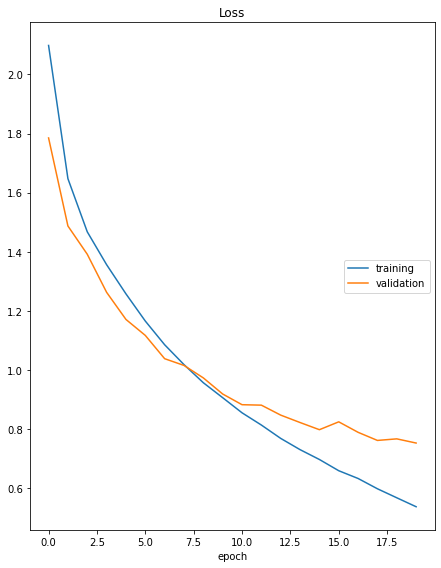

Loss
	training         	 (min:    0.538, max:    2.098, cur:    0.538)
	validation       	 (min:    0.753, max:    1.785, cur:    0.753)


In [13]:
optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    20,
    "cifar10_best_valid.pt",
    interactive_tracking=True
)

###  Load the Model with the Lowest Validation Loss

In [14]:
model.load_state_dict(torch.load('cifar10_best_valid.pt'))

<All keys matched successfully>

---
## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [15]:
from helpers import one_epoch_test

In [16]:
test_loss, preds, actuals = one_epoch_test(data_loaders['valid'], model, loss)

Testing: 100%|███████████████████████████████| 500/500 [00:03<00:00, 153.56it/s]

Test Loss: 0.752981


Test Accuracy: 74% (7414/10000)


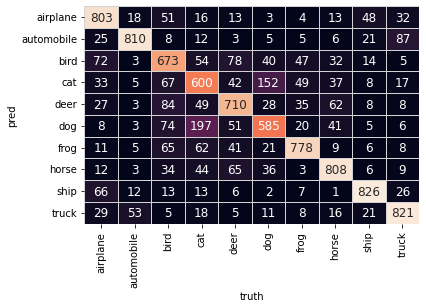

In [17]:
from helpers import plot_confusion_matrix

cm = plot_confusion_matrix(preds, actuals, classes)

In [18]:
print("Accuracy by class:\n")
for i, col in enumerate(cm):
    print(f"    {col:11s}: {cm[col][i] / cm[col].sum():.2f}")

Accuracy by class:

    airplane   : 0.74
    automobile : 0.89
    bird       : 0.63
    cat        : 0.56
    deer       : 0.70
    dog        : 0.66
    frog       : 0.81
    horse      : 0.79
    ship       : 0.86
    truck      : 0.81


### Question: What are your model's weaknesses and how might they be improved?

**Answer**: This model seems to do best on vehicles rather than animals. For example, it does best on the automobile class and worst on the cat class. I suspect it's because animals vary in color and size and so it would improve this model if I could increase the number of animal images in the first place or perhaps if I added another convolutional layer to detect finer patterns in these images. I could also experiment with a smaller learning rate so that the model takes small steps in the right direction as it is training.

_NOTE_: we will see how to improve the performances even further with simple things like data augmentation and batch norm

### Visualize Sample Test Results

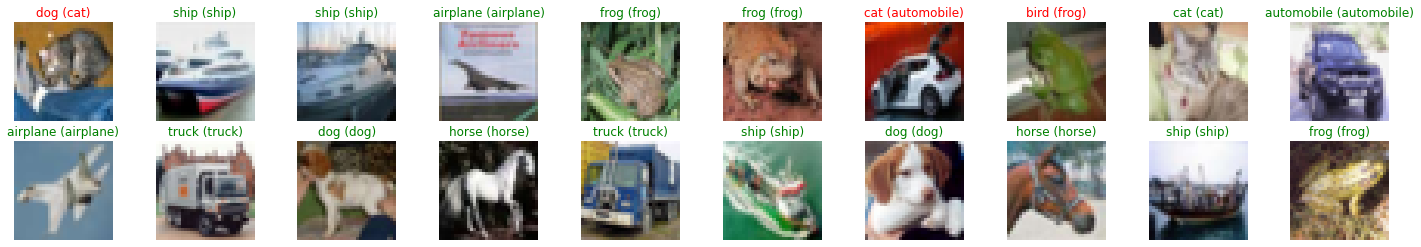

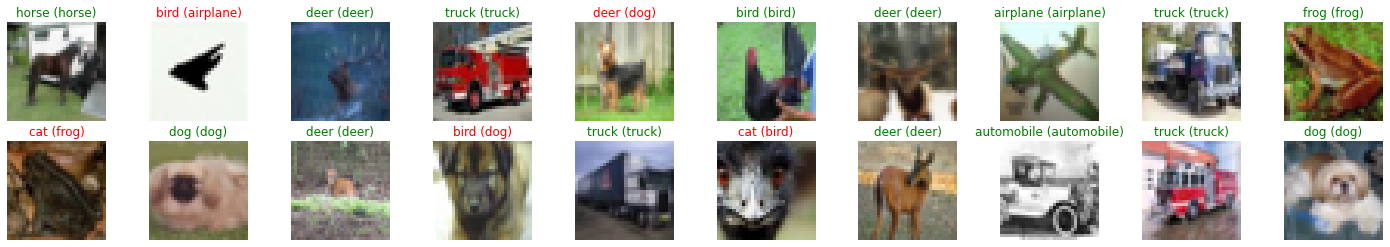

In [19]:
# obtain one batch of test images
dataiter = iter(data_loaders['test'])

for i in range(2):
    images, labels = dataiter.next()
    images.numpy()

    # move model inputs to cuda, if GPU available
    if train_on_gpu:
        images = images.cuda()

    # get sample outputs
    output = model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

    # plot the images in the batch, along with predicted and true labels
    fig, subs = plt.subplots(2, 10, figsize=(25, 4))
    for i, ax in enumerate(subs.flatten()):
        imshow(images[i].cpu().numpy(), ax)
        ax.set_title("{} ({})".format(classes[preds[i]], classes[labels[i]]),
                     color=("green" if preds[i]==labels[i].item() else "red"))
        ax.axis("off")